In [34]:
import numpy as np
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [35]:

# 1. Create the Bayesian network
bn = gum.BayesNet("StudentPerformance")

# 2. Add nodes (0 = low/poor, 1 = high/good), except FinalGrade has 4 states
for name, states in [
    ("Motivation", 2),
    ("PriorKnowledge", 2),
    ("StudyTime", 2),
    ("Attendance", 2),
    ("Engagement", 2),
    ("Understanding", 2),
    ("AssignmentPerf", 2),
    ("ExamAnxiety", 2),
    ("ExamPerf", 2),
    ("FinalGrade", 4)   # 0=F,1=C,2=B,3=A
]:
    bn.add(name, states)

# 3. Define the DAG structure
arcs = [
    ("Motivation", "StudyTime"),
    ("Motivation", "Engagement"),
    ("PriorKnowledge", "Understanding"),
    ("Attendance", "Engagement"),
    ("StudyTime", "Understanding"),
    ("Engagement", "Understanding"),
    ("Understanding", "AssignmentPerf"),
    ("Understanding", "ExamPerf"),
    ("ExamAnxiety", "ExamPerf"),
    ("AssignmentPerf", "FinalGrade"),
    ("ExamPerf", "FinalGrade")
]
for p, c in arcs:
    bn.addArc(p, c)

# 4. Define CPTs

# 4.1 Root nodes
bn.cpt("Motivation").fillWith([0.4, 0.6])
bn.cpt("PriorKnowledge").fillWith([0.5, 0.5])
bn.cpt("Attendance").fillWith([0.3, 0.7])
bn.cpt("ExamAnxiety").fillWith([0.6, 0.4])

# 4.2 StudyTime | Motivation
cpt = bn.cpt("StudyTime")
cpt[{"Motivation": 0, "StudyTime": 1}] = 0.3
cpt[{"Motivation": 0, "StudyTime": 0}] = 0.7
cpt[{"Motivation": 1, "StudyTime": 1}] = 0.8
cpt[{"Motivation": 1, "StudyTime": 0}] = 0.2

# 4.3 Engagement | Motivation, Attendance
cpt = bn.cpt("Engagement")
for mot in [0, 1]:
    for att in [0, 1]:
        if mot + att == 0:
            p = 0.2
        elif mot + att == 1:
            p = 0.5
        else:
            p = 0.9
        cpt[{"Motivation": mot, "Attendance": att, "Engagement": 1}] = p
        cpt[{"Motivation": mot, "Attendance": att, "Engagement": 0}] = 1 - p

# 4.4 Understanding | PriorKnowledge, StudyTime, Engagement
cpt = bn.cpt("Understanding")
for pk in [0, 1]:
    for st in [0, 1]:
        for eg in [0, 1]:
            score = pk + st + eg
            p = {0: 0.1, 1: 0.3, 2: 0.7, 3: 0.9}[score]
            cpt[{"PriorKnowledge": pk, "StudyTime": st,
                 "Engagement": eg, "Understanding": 1}] = p
            cpt[{"PriorKnowledge": pk, "StudyTime": st,
                 "Engagement": eg, "Understanding": 0}] = 1 - p

# 4.5 AssignmentPerf | Understanding
cpt = bn.cpt("AssignmentPerf")
cpt[{"Understanding": 0, "AssignmentPerf": 1}] = 0.4
cpt[{"Understanding": 0, "AssignmentPerf": 0}] = 0.6
cpt[{"Understanding": 1, "AssignmentPerf": 1}] = 0.9
cpt[{"Understanding": 1, "AssignmentPerf": 0}] = 0.1




In [36]:
# 4.6 ExamPerf | Understanding, ExamAnxiety
cpt = bn.cpt("ExamPerf")
for und in [0, 1]:
    for anx in [0, 1]:
        if und == 0 and anx == 1:
            p = 0.2
        elif und == 1 and anx == 0:
            p = 0.8
        else:
            p = 0.5
        cpt[{"Understanding": und, "ExamAnxiety": anx, "ExamPerf": 1}] = p
        cpt[{"Understanding": und, "ExamAnxiety": anx, "ExamPerf": 0}] = 1 - p

# 4.7 FinalGrade | AssignmentPerf, ExamPerf
cpt = bn.cpt("FinalGrade")
for ap in [0,1]:
    for ep in [0,1]:
        if ap==1 and ep==1:
            probs = [0.0,0.1,0.4,0.5]
        elif ap==1:
            probs = [0.0,0.3,0.5,0.2]
        elif ep==1:
            probs = [0.0,0.2,0.4,0.4]
        else:
            probs = [0.5,0.3,0.1,0.1]

        for state, pr in enumerate(probs):
            # use cpt[ap, ep, state] rather than cpt[[ap,ep,state]]
            cpt[ap, ep, state] = pr


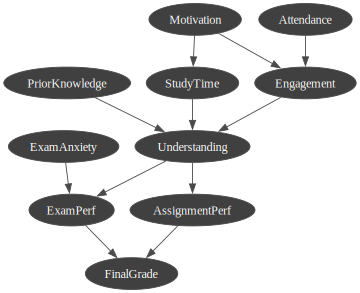

In [37]:
# Display interactive SVG in the notebook
gnb.showBN(bn)

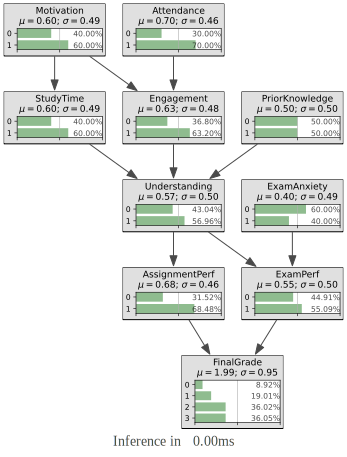

In [38]:
gnb.showInference(bn, evs={})


In [43]:
# Assuming 'bn' is your Bayesian network
generator = gum.BNDatabaseGenerator(bn)
nr = 10000
generator.drawSamples(nr)
df = generator.to_pandas()

# Save it to a CSV file
df.to_csv(f'data_sample_{nr}.csv', index=False)